## Denoising Diffusion Probabilistic Models


In [6]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
batch_size = 128

trainset = datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

In [7]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 64),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    )
).to(device)

### Training Setup

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
opt = torch.optim.Adam(model.parameters())

n_epochs = 20

In [10]:
for epoch in range(n_epochs):
    for i, data in enumerate(train_loader):
        opt.zero_grad()
        x = data[0].to(device)
        noise = torch.randn(x.shape, device=device)
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (batch_size,), device=device, dtype=torch.int64
        )
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
        noise_pred = model(noisy_x, timesteps)[0]
        loss = torch.nn.functional.mse_loss(noise_pred, noise)

        loss.backward()
        opt.step()

        print(f"epoch: {epoch}, steps: {i}, loss: {loss.item():.4}", end="\r")

torch.save(model.state_dict(), './model.ckpt')

### DDIM Sampling and visualization

DDIM Sampling::   0%|          | 0/100 [00:00<?, ?it/s]

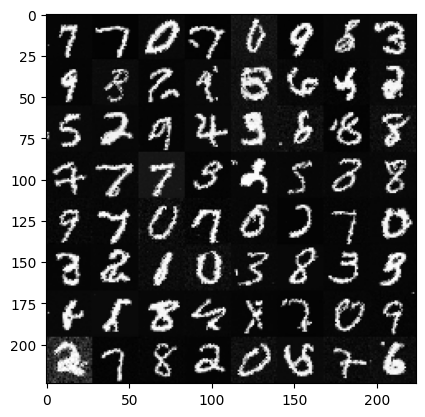

In [11]:
from diffusers import DDIMScheduler, UNet2DModel
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cpu')

model = model.to(device)

sampling_bs = 64
steps = 100
generator=torch.Generator(device=device)

sampler = DDIMScheduler(
    num_train_timesteps=1000
)

latents = torch.randn((sampling_bs, 1, 28, 28), device=device, generator=generator, dtype=torch.float32)
latents = latents * sampler.init_noise_sigma
sampler.set_timesteps(steps)
timesteps = sampler.timesteps.to(device)

extra_step_kwargs = {
    'eta': 0.0,
    'generator': generator
}

for i, t in enumerate(tqdm(timesteps, desc="DDIM Sampling:", leave=False)):
    model_input = latents

    timestep_tensor = torch.tensor([t], dtype=torch.long, device=device)
    timestep_tensor = timestep_tensor.expand(latents.shape[0])
    noise_pred = model(model_input, timestep_tensor)[0]

    latents = sampler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

grid = make_grid(
    latents.clip(-1, 1), value_range=(-1, 1), padding=0, nrow=8
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()